# Inrodução

Nesse notebook os experimentos da modelagem das categorias é realizada.
As evidências de encontradas na análise auxiliaram na seleção de variáveis e
elaboração de features para o modelo.

Ao final desse notebook teremos uma estrutura de pipeline treinada e o com
hiperparâmetros otimizados (escopo de busca de hiperparâmetros limitada para
diminuir o tempo de treinamento).

# Imports

In [1]:
# imports do scikit-learn para a modelagem

# preprocessamento nlp e modelagem de tópicos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
# modelagem de árvores
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# avaliação e seleção de modelos
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
# criação de pipelines
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [183]:

# funções gerais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

In [3]:
from pathlib import Path
import sys

main_path = str(Path().resolve().parent)
sys.path.append(main_path)

In [5]:
# carregando as funções de preprocessamento nlp do notebook de
# análise de produto, essas funções foram adicionadas nesse modulo
from src import nlp_preprocessing

# Carregamento dos dados

Serão carregados os dados de treinamento já com o pré-processamento geral
realizado na primeira etapa de análise.

In [6]:
df_train = pd.read_pickle("../data/train_prod.pickle")
df_train.head()

,seller_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
product_id,,,,,,,,,,,
7010568,761717,Caneta Personalizada Barquinho,caneta personalizada canetas personalizadas pa...,2017-07-12 16:29:08,12.260,15.0,0,30.0,116.0,11.0,Lembrancinhas
6957815,3708390,Toalha Bordada Madrinha de Consagração,toalhas lavabo lembrancinhas batizado toalha c...,2016-12-08 10:40:28,28.490,7.5,1,4.5,463.0,8.5,Lembrancinhas
10378129,8225602,Colar Best Friends Folheado 4 Partes.,biju best friends mirella flavia gabi,2017-01-24 14:32:48,40.290,13.0,0,0.0,9183.0,157.0,Bijuterias e Jóias
4658013,7043431,Azulejo Certificado Melhor Pai do Mundo,dia pais azulejos,2019-06-14 16:09:23,39.220,338.0,0,1.0,77.5,12.0,Decoração
487440,1408350,Mochila saco bailarina soldadinho de chumbo,sacolinhas festa bailarina lembrancinhas baila...,2018-02-21 16:39:27,13.175,12.5,1,32.0,1484.5,0.0,Lembrancinhas


# Avaliação inicial da extração de features para a modelagem

Nessa etapa vamos avaliar a combinação de diversos features para geração
do modelo de previsão de categorias. Serão testadas com features base nos
dados de produtos com combinações de novas features extraídas das variáveis
textuais `title` e `concatenated_tags` a partir de modelagem de tópicos por
NMF.

Primeiro vamos aplicar a função `gen_topics` para a obtenção das features de 
tópicos nos dados textuais. Essas novas features vão ser combinadas com os
dados base de modo a termos, dados base, dados base mais tópicos de título,
dados base mais tópicos de tags e por último os dados completos com todas as
features geradas.

In [7]:
def gen_topics(doc: pd.Series, n_topics: int) -> pd.DataFrame:
    """Função que aplica a modelagem de tópicos para 

    Args:
        doc (pd.Series): _description_
        n_topics (int): _description_

    Returns:
        pd.DataFrame: _description_
    """    
    tfidf_vec = TfidfVectorizer(tokenizer=nlp_preprocessing.custom_tokenizer,
                                preprocessor=nlp_preprocessing.clean_text,
                                min_df=10,
                                max_df=0.9)
    tfidf_data = tfidf_vec.fit_transform(doc)
    topic_model = NMF(n_components=n_topics, init="random")
    topic_data = topic_model.fit_transform(tfidf_data)
    columns = [f"{doc.name}_{i}" for i in range(n_topics)]
    return pd.DataFrame(topic_data, index=doc.index, columns=columns)

In [12]:
y_train = df_train["category"]

In [13]:
# remoção de variáveis que não vão ser utilizadas
base_train = df_train.drop(columns=["seller_id", "title", "concatenated_tags",
                                    "creation_date", "category"])

# geração do dataframe com tópicos de títulos e tags
title_topics = gen_topics(df_train["title"], 5)
tags_topics = gen_topics(df_train["concatenated_tags"], 5)
# fazendo as três combinações de dados
base_title_train = base_train.join(title_topics)
base_tags_train = base_train.join(tags_topics)
full_train = base_train.join(title_topics).join(tags_topics)

# criando o dicionário que reune todos os dados criados
train_sets = [("base", base_train),
              ("base_title", base_title_train),
              ("base_tag", base_tags_train),
              ("full_train", full_train)]

A capacidade dos dados em prever a categoria será testada a partir da função
`test_data_modeling`. Essa função irá utilizar os dados e o modelo para 
treinamento. Calculará o score esperado utilizando validação cruzada de 5
dobras. A avalicão será por meio do indicador de F1-score, ponderado pela
prevalência de cada classe. Serão calculados a média e o desvio padrão desse
score utilizando o resultado de todas as dobras. Esse será uma proxy ao nosso
desempenho de generalização esperado. Para o modelo treinado, será identificada
a importância de cada parâmetro utlizado na modelagem. Ainda, é aplicada a
função `classification_report` do desepemno do modelo com dados de treinamento.
Por fim, é calculado o desepenho em treinameto (também utilizando o F1-score)
e é printado o resultados da validação cruzada e do desempenho com dados de 
treinamento.

O score F1 foi selecionado pois ele combina precision e recall em um
identificador só. A agergação dos scores para cada categoria é agregada por
meio de uma média ponderada a partir da frequência de cada categoria. Essa
ponderação é importante tendo em vista o desbalanceamento entre as classes. A
utilização dessa estatística faz sentido uma vez que não temos razão para 
priorizar nem precisão e nem recall.

Poderíamos sofisticar um pouco mais o score do modelo. Por exemplo, de forma
a ponderar o desemepenho de cada f1-score a partir da frequência relativa da
categoria, poderíamos fazer uma média com base em pesos que representem o total
de pedidos ou então o valor total transacionado por categoria. Dessa forma,
iriamos dar mais importância para aquelas categorias que movimentem maiores
transações. Outra forma, seria pela lucratividade média de cada categoria para
o marketplace. Ou seja tudo depende do que tipo de importância queremos dar
para cada categoria. Para simplifcar o problema vamos adotar o método padrão
com ponderação pela frequência relativa. Como estamos trabalhando com dados de
queries ao realizar isso, estamos previlegiando aquelas categorias de produtos
que são mais buscados pelos compradores, o que em si também tem seu mérito.

In [14]:
def test_data_modeling(X_train: pd.DataFrame, y_train: pd.Series, model) -> None:
    """Gera várias visualizações para avaliar o desempenho do treinamento

    Args:
        X_train (pd.DataFrame): _description_
        y_train (pd.Series): _description_
        model (sklearn.model): _description_
    """
    
    # treinando o modelo com validação cruzada
    cv_score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1,
                               scoring=make_scorer(f1_score,
                                                   average='weighted'))
    mean_score = cv_score.mean()
    std_score = cv_score.std()
    # treinando o modelo
    model.fit(X_train, y_train)
    # plotando a importância dos parâmetros
    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    importances.sort_values().plot(kind="barh")
    plt.show()
    
    # gerando o classification report
    y_pred = model.predict(X_train)
    print(classification_report(y_train, y_pred))
    # finalizando com um print, do score de treinamento e das médias e
    # desvios padrões dos scores de validação cruzada
    train_score = f1_score(y_train, y_pred, average="weighted")
    print({"train_score": train_score,
           "cv_mean_score": mean_score,
           "cv_std_score": std_score})

Como o objetivo dessa etapa é mais avaliar a utilização dos dados que o próprio
modelo será utilizada um modelo mais simples de classificação em árvore. Não
haverá qualquer esforço em escolher um modelo com a melhor combinação de
hiperparâmetros nessa etapa, apenas testar diversas combinações de atributos
para a previsão de categorias.

Por ser um modelo de árvores que é capaz de incorporar relações não lineares
entre os atributos, não será aplicada a escala logarítimica sobre os atributos
preço e peso, como foi realizado na análise exploratória.

A função será aplicada para cada conjunto de dados contidos no dicionário
`train_sets`. Para todos será utilizado o modelo de árvore.

base


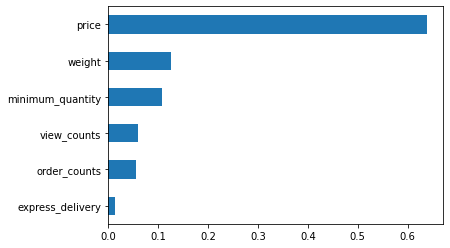

                    precision    recall  f1-score   support

              Bebê       0.54      0.50      0.52      3809
Bijuterias e Jóias       0.46      0.34      0.39       604
         Decoração       0.60      0.72      0.66      5167
     Lembrancinhas       0.77      0.88      0.82      8931
            Outros       0.34      0.09      0.14       710
       Papel e Cia       0.49      0.09      0.15      1602

          accuracy                           0.67     20823
         macro avg       0.53      0.44      0.45     20823
      weighted avg       0.64      0.67      0.64     20823

{'train_score': 0.6372581704775625, 'cv_mean_score': 0.5683367458914999, 'cv_std_score': 0.00403296785207402}
----------------------------------------------------------------------------------------------------
base_title


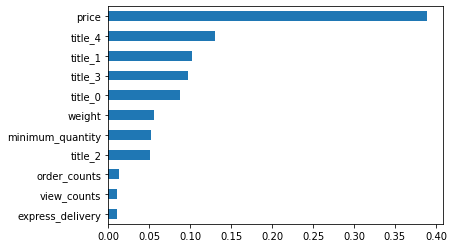

                    precision    recall  f1-score   support

              Bebê       0.71      0.67      0.69      3809
Bijuterias e Jóias       0.63      0.60      0.61       604
         Decoração       0.75      0.80      0.78      5167
     Lembrancinhas       0.84      0.91      0.87      8931
            Outros       0.44      0.27      0.34       710
       Papel e Cia       0.63      0.36      0.46      1602

          accuracy                           0.77     20823
         macro avg       0.67      0.60      0.62     20823
      weighted avg       0.76      0.77      0.76     20823

{'train_score': 0.7579940434645872, 'cv_mean_score': 0.7025947576937943, 'cv_std_score': 0.004795236417812885}
----------------------------------------------------------------------------------------------------
base_tag


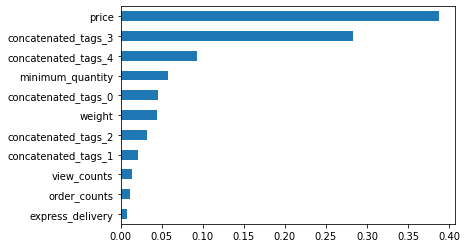

                    precision    recall  f1-score   support

              Bebê       0.80      0.72      0.76      3809
Bijuterias e Jóias       0.61      0.58      0.59       604
         Decoração       0.72      0.82      0.77      5167
     Lembrancinhas       0.83      0.90      0.86      8931
            Outros       0.56      0.25      0.35       710
       Papel e Cia       0.56      0.32      0.41      1602

          accuracy                           0.77     20823
         macro avg       0.68      0.60      0.62     20823
      weighted avg       0.76      0.77      0.76     20823

{'train_score': 0.7605383380789124, 'cv_mean_score': 0.7088259086954747, 'cv_std_score': 0.007825404940188668}
----------------------------------------------------------------------------------------------------
full_train


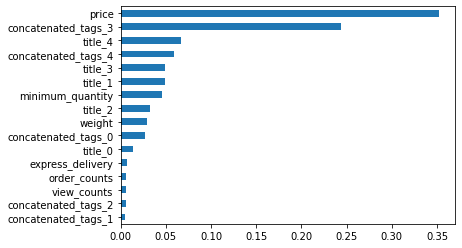

                    precision    recall  f1-score   support

              Bebê       0.78      0.74      0.76      3809
Bijuterias e Jóias       0.71      0.58      0.64       604
         Decoração       0.77      0.82      0.80      5167
     Lembrancinhas       0.84      0.92      0.88      8931
            Outros       0.48      0.25      0.33       710
       Papel e Cia       0.57      0.40      0.47      1602

          accuracy                           0.79     20823
         macro avg       0.69      0.62      0.65     20823
      weighted avg       0.78      0.79      0.78     20823

{'train_score': 0.7802608483393072, 'cv_mean_score': 0.7282328639174418, 'cv_std_score': 0.010337319621015455}
----------------------------------------------------------------------------------------------------


In [11]:
model = DecisionTreeClassifier(random_state=23, min_samples_leaf=0.001)
for name, data in train_sets:
    print(name)
    test_data_modeling(data, y_train, model)
    print("-"* 100)

Como é possível observar, conforme vamos aumentando a quantidade de atributos
o desempenho do modelo vai aumentando. Tanto o score de treino quanto o score
de validação cruzada vão aumentando. Isso é um indício de que mesmo com o
crescimento da quantidade de atributos não estamos incorrendo em uma situação
de sobrespecificação. Apesar disso, no último modelo temos um pequeno aumento
na dispersão dos scores da validação cruzada, o que pode ser uma alerta caso
o modelo acabe se tornando muito sensível a pequenas variações nos dados de
treinamento e possa sobrespecificar.

Outro ponto importante é que conforme vamos adicionando mais atibutos a
importância dos atributos base vai decrescendo. Ainda assim, três atributos
continuam sendo importantes mesmo no modelo com a maior quantidade de
atributos: preço, quantidade mínima e peso. Esse resultado está consoante ao
que foi identificado na análise descritiva. As outras três variáveis podem ser
consideradas despresíveis para a modelagem. Estando de forma consistente entre
as últimas posições de importância.

Um outro padrão importante é que quando adicionamos tópicos de títulos e tags,
acaba ocorrendo duplicidade na informação passada para o modelo, com isso,
alguns desses tópicos acabam também se tornando dispensáveis uma vez que sua
informação já está sendo utilizada por um outro tópico.

Definida essa primeira base de comparação cabe agora buscar otimizar a
definições dos hiperparâmetros com o intuito de obter um modelo de melhor
desempenho. Ao invés de utilizar a modelagem de árvore mais simples, nessa
próxima etapa utilizaremos modelagem de floresta que combina diversos modelos
de árvore em um só e reduz os riscos de sobresespecificação inerentes aos
modelos de árvore.

# Treinando o pipeline de treinamento

Para fazer essa otimização iremos utilizar um `Pipline` de treinamento. Esse
pipeline irá reunir as tarefas de seleção de dados e extração de tópicos das
variáveis textuais para formar as features e por fim irá treinar o modelo
de `RandomForestClassifier`.

In [16]:
def gen_topic_transformer(column_name: str) -> Pipeline:
    """Gera um pipeline de geração de tópicos NMF a partir de um nome de coluna

    Args:
        column_name (str): nome da feature utilizada

    Returns:
        Pipeline: pipeline de tópicos NMF
    """    
    return Pipeline(steps=[
        ("selector", FunctionTransformer(lambda x: x[column_name])),
        ("tfidf", TfidfVectorizer(tokenizer=nlp_preprocessing.custom_tokenizer,
                                  preprocessor=nlp_preprocessing.clean_text,
                                  min_df=10,
                                  max_df=0.9)),
        ("nmf", NMF(init="random", max_iter=1000, random_state=23))
    ])

In [17]:
# criando o FeatureUnion que irá gerar os dados para a modelagem
cols = ["price", "weight", "minimum_quantity"]
features_pipelines = FeatureUnion([
    ("title", gen_topic_transformer("title")),
    ("tags", gen_topic_transformer("concatenated_tags")),
    ("selector", FunctionTransformer(lambda x: x[cols]))
])
# criando o pipeline completo
pipeline = Pipeline([
    ("preprocessing", features_pipelines),
    ("rf", RandomForestClassifier(random_state=23))
])

In [19]:
# criando o grid onde a busca será realizada para encontrar a melhor combinação
# de hiperparâmetros estamos fazendo a busca pela quantidade de componentes
# pela quantidade de estimadores de uma floresta e pela profundida
# quanto maior a profundidadae mais complexa e maior a possibilidade de
# sobrespecificar.
params_grid = {"preprocessing__title__nmf__n_components": [10, 25, 50],
               "preprocessing__tags__nmf__n_components": [10, 25, 50],
               "rf__n_estimators": [500, 1000, 1500],
               "rf__max_depth": [10, 15, 20, 25, 50]}

grid_rf = GridSearchCV(pipeline, params_grid, cv=5, verbose=1)
grid_rf.fit(df_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('title',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function gen_topic_transformer.<locals>.<lambda> at 0x000001DA9A2950D0>)),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(max_df=0.9,
                                                                                                         min_df=10,
                                                                                                         preprocessor=<function clean_text at 0x000001DA97640A60>,
                                                          

Resultado estranho, fortes indícios de sobresepecificação por conta do score
máximo para precisão e recall em todas as categorias, ou seja, conseguimos
reproduzir perfeitamente os dados.

In [22]:
# avaliando o melhor modelo utilizando dados de treinamento
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(df_train)
print(classification_report(y_true=y_train, y_pred=y_pred))

                    precision    recall  f1-score   support

              Bebê       1.00      1.00      1.00      3809
Bijuterias e Jóias       1.00      1.00      1.00       604
         Decoração       1.00      1.00      1.00      5167
     Lembrancinhas       1.00      1.00      1.00      8931
            Outros       1.00      1.00      1.00       710
       Papel e Cia       1.00      1.00      1.00      1602

          accuracy                           1.00     20823
         macro avg       1.00      1.00      1.00     20823
      weighted avg       1.00      1.00      1.00     20823



Pelo gráfico com os resultados dos experimentos, vemos que a quantidade de
componentes (soma de tópicos de título e tags) e o tamanho das árvores são
fatores determinantes. Porém, vemos também que a melhora que eles proporcionam
é decrescente. O incremento é muito pequeno quando passamos de uma profundida
máxima de 25 para 50. O mesmo ocorre quando alteramos a quantidade máxima de
tópicos de 50 para 100. De certo modo, só conseguimos extrair maior proveito
da maior quantidade de componentes quando possibilitamos a geração de árvores
maiores, o que é bastante intuitivo.

In [61]:
results = pd.DataFrame(grid_rf.cv_results_["params"])
results["mean_test_score"] = grid_rf.cv_results_["mean_test_score"]
results["std_test_score"] = grid_rf.cv_results_["std_test_score"]
results["n_components"] = (results["preprocessing__tags__nmf__n_components"] +
                           results["preprocessing__title__nmf__n_components"])
results

,preprocessing__tags__nmf__n_components,preprocessing__title__nmf__n_components,rf__max_depth,rf__n_estimators,mean_test_score,std_test_score,n_components
0,10,10,10,500,0.799260,0.007561,20
1,10,10,10,1000,0.799932,0.007045,20
2,10,10,10,1500,0.799500,0.007165,20
3,10,10,15,500,0.833165,0.005207,20
4,10,10,15,1000,0.833501,0.004684,20
...,...,...,...,...,...,...,...
130,50,50,25,1000,0.854247,0.004056,100
131,50,50,25,1500,0.853623,0.003742,100
132,50,50,50,500,0.860634,0.004582,100
133,50,50,50,1000,0.860394,0.004554,100


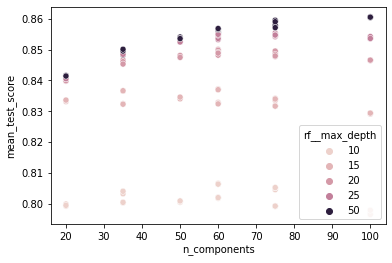

In [68]:
(sns.scatterplot(data=results,
                 x="n_components",
                 y="mean_test_score",
                 hue="rf__max_depth"))
plt.show()

In [69]:
results.groupby("rf__n_estimators")["mean_test_score"].mean()

rf__n_estimators
500     0.837396
1000    0.837490
1500    0.837428
Name: mean_test_score, dtype: float64

Com base nesses resultados um novo experimento será realizado. Focalizando
melhor nas features que podem trazer resultado e adicionando novas features
para a busca.

In [81]:
# criando o grid onde a busca será realizada para encontrar a melhor combinação
# de hiperparâmetros estamos fazendo a busca pela quantidade de componentes
# pela quantidade de estimadores de uma floresta e pela profundida
# quanto maior a profundidadae mais complexa e maior a possibilidade de
# sobrespecificar.
params_grid = {"preprocessing__title__nmf__n_components": [10, 25],
               "preprocessing__tags__nmf__n_components": [10, 25],
               "rf__n_estimators": [500],
               "rf__max_depth": [15, 20, 25],
               "rf__min_samples_leaf": [0.001, 0.0005, 0.0001]}

new_grid_rf = GridSearchCV(pipeline, params_grid, cv=5, verbose=1,
                           return_train_score=True)
new_grid_rf.fit(df_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('title',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function gen_topic_transformer.<locals>.<lambda> at 0x000001DA9A2950D0>)),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(max_df=0.9,
                                                                                                         min_df=10,
                                                                                                         preprocessor=<function clean_text at 0x000001DA97640A60>,
                                                          

In [82]:
# avaliando o melhor modelo utilizando dados de treinamento
best_model = new_grid_rf.best_estimator_
y_pred = best_model.predict(df_train)
print(classification_report(y_true=y_train, y_pred=y_pred))

                    precision    recall  f1-score   support

              Bebê       0.97      0.93      0.95      3809
Bijuterias e Jóias       0.99      0.90      0.94       604
         Decoração       0.95      0.97      0.96      5167
     Lembrancinhas       0.93      0.99      0.96      8931
            Outros       1.00      0.70      0.82       710
       Papel e Cia       0.98      0.81      0.89      1602

          accuracy                           0.95     20823
         macro avg       0.97      0.88      0.92     20823
      weighted avg       0.95      0.95      0.95     20823



In [83]:
results = pd.DataFrame(new_grid_rf.cv_results_["params"])
results["mean_test_score"] = new_grid_rf.cv_results_["mean_test_score"]
results["std_test_score"] = new_grid_rf.cv_results_["std_test_score"]
results["n_components"] = (results["preprocessing__tags__nmf__n_components"] +
                           results["preprocessing__title__nmf__n_components"])
results.head()

,preprocessing__tags__nmf__n_components,preprocessing__title__nmf__n_components,rf__max_depth,rf__min_samples_leaf,rf__n_estimators,mean_test_score,std_test_score,n_components
0,10,10,15,0.0010,500,0.807472,0.006019,20
1,10,10,15,0.0005,500,0.816501,0.005385,20
2,10,10,15,0.0001,500,0.829707,0.005259,20
3,10,10,20,0.0010,500,0.808769,0.005692,20
4,10,10,20,0.0005,500,0.818518,0.005213,20


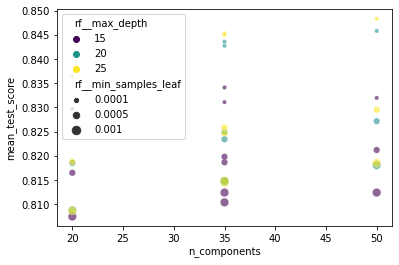

In [84]:
(sns.scatterplot(data=results,
                 x="n_components",
                 y="mean_test_score",
                 hue="rf__max_depth",
                 size="rf__min_samples_leaf",
                 alpha=0.6,
                 palette="viridis"))
plt.show()

In [102]:
# avaliando o melhor modelo utilizando dados de teste
df_test = pd.read_pickle("../data/test_prod.pickle")
y_test = df_test["category"]
y_pred = best_model.predict(df_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

                    precision    recall  f1-score   support

              Bebê       0.88      0.79      0.83      1633
Bijuterias e Jóias       0.96      0.76      0.85       259
         Decoração       0.83      0.91      0.87      2215
     Lembrancinhas       0.85      0.96      0.90      3828
            Outros       0.85      0.30      0.44       304
       Papel e Cia       0.86      0.48      0.61       686

          accuracy                           0.85      8925
         macro avg       0.87      0.70      0.75      8925
      weighted avg       0.85      0.85      0.84      8925



In [187]:
title_nmf_params = best_model.named_steps["preprocessing"].transformer_list[0][1][2].get_params()
tags_nmf_params = best_model.named_steps["preprocessing"].transformer_list[1][1][2].get_params()
rf_params = best_model.named_steps["rf"].get_params()

params_dict = {"title_nmf": title_nmf_params,
               "tags_nmf": tags_nmf_params,
               "rf_category_clf": rf_params}

for name, params in params_dict.items():
    file_path = f"..\config\{name}.json"
    with open(file_path, "w") as file:
        json.dump(params, file, indent=4)

In [138]:
base_cols = ["price", "weight", "minimum_quantity"]
title_columns = [f"titles_{n}"
                 for n in range(title_nmf_params["n_components"])]
tags_columns = [f"tags_{n}"
                for n in range(tags_nmf_params["n_components"])]
columns = title_columns + tags_columns + base_cols
len(columns)

53

[]

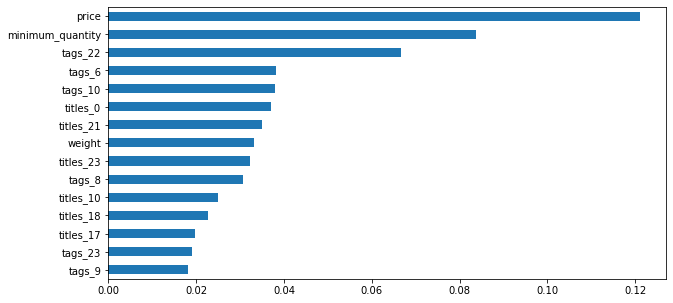

In [141]:
best_model.named_steps["rf"].feature_importances_
importances = pd.Series(best_model.named_steps["rf"].feature_importances_,
                        index=columns)
top_15_importances = importances.sort_values().tail(15)
top_15_importances.plot(kind="barh", figsize=(10, 5))
plt.plot()

In [181]:
top_tags_ids = (top_15_importances.
                index[top_15_importances.index.str.contains("tags")].
                str.replace("tags_", "").tolist())
top_title_ids = (top_15_importances.
                 index[top_15_importances.index.str.contains("title")].
                 str.replace("titles_", "").tolist())

In [172]:
topic_pipe = {
    "title": {
        "tfidf": best_model.named_steps["preprocessing"].transformer_list[0][1][1],
        "nmf": best_model.named_steps["preprocessing"].transformer_list[0][1][2],
    },
    "tags": {
        "tfidf": best_model.named_steps["preprocessing"].transformer_list[1][1][1],
        "nmf": best_model.named_steps["preprocessing"].transformer_list[0][1][2],
    }
}

In [174]:
def show_top_words(topic_model, tfidf_vec, components, n_words=10):
    """Visualização dos top tokens por componente do NMF

    Args:
        topic_model (_type_): modelo NMF treinado
        tfidf_vec (_type_): objeto vetorizador TF-IDF
        n_words (int, optional): número de top tokens. Defaults to 10.
    """
    for i in components:
        component = topic_model.components_[int(i)]
        top_words_ids = list(component.argsort()[:-n_words - 1: -1])
        top_words_list = tfidf_vec.get_feature_names_out()[top_words_ids]
        print(f"Topic {i} - {' | '.join(top_words_list)}")

In [182]:
show_top_words(topic_pipe["title"]["nmf"], topic_pipe["title"]["tfidf"], top_title_ids)

Topic 17 - matern | said | bols | menin | saqu | pec | urs | mal | mochil | enfeit
Topic 18 - cas | canec | padr | noiv | madr | convit | alianc | necessa | bem | par
Topic 10 - decor | plac | espelh | garraf | sal | acril | quart | aluguel | vas | mold
Topic 23 - bebe | mant | menin | body | quart | higien | album | sapat | casac | nom
Topic 21 - lembranc | nasc | aromatiz | aniversari | profes | matern | format | urs | minni | sabonet
Topic 0 - person | canec | canet | lat | mochil | necessa | acril | chinel | fest | tac


In [179]:
show_top_words(topic_pipe["tags"]["nmf"], topic_pipe["tags"]["tfidf"], top_tags_ids)

Topic 9 - nom | ped | digit | gustav | bich | li | faz | gal | cadern | lim
Topic 23 - barb | led | listr | bernard | paj | geometr | algoda | plann | cap | marc
Topic 8 - brun | math | lol | coleco | adult | dat | gab | bann | ann | ombr
Topic 10 - cour | nen | dossel | fl | pijam | adult | paj | amand | saqu | lun
Topic 6 - hel | geometr | bat | mochil | noiv | espac | bibl | permanent | bar | paul
Topic 22 - alv | caf | marinh | mud | espac | raf | sal | permanent | brinqued | gravat
